# Isoflow main notebook

In this notebook we showcase the main results achieved in the project, by sampling / generating data and evaluating it against train or test data.

### Loading libraries

In [1]:
import sys
import torch
import scanpy as sc
import anndata as ad

sys.path.append("/dtu/blackhole/1e/213566/Isoflow")
#from utils.autoencoder_utils import NB_Autoencoder 
#from autoencoder_utils import sample_nb

### Loading data

- Loading of test data

In [2]:
test_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train.h5ad"

# Test data
adata_test = sc.read_h5ad(test_path)

sc.pp.filter_genes(adata_test, min_cells=20) #remove genes with low count

adata_test.obs["dataset"] = "test"

- Loading of already decoded generated data

In [3]:
data_dir = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/"
gen_adata_path = data_dir + "generated_anndata.h5ad" #where we will save adata generated

adata_gen = sc.read_h5ad(gen_adata_path)

sc.pp.filter_genes(adata_test, min_cells=20)

adata_gen.obs["dataset"] = "generated"

## Quantitative evaluation

We will compare generated data to (held-out) real data by calculating MMD and 2-wassertein distance between first 30 PCs, projected using real data PC loadings.

In [8]:
#Compare generated data
from utils.compute_metrics import compute_metrics

W1, W2, MMD = compute_metrics(test_path, gen_adata_path, subsample=True)
print(W1, W2, MMD)

8.33016357910402 81.18092773495704 0.49624595


The distances show our generated distribution is quite similar to the test data, within the range of the distances achieved in the CFGen paper. It is important to note that tehse distances are not strictly comparable as we designed a simpler implementation.

## Qualitative evaluation

### UMAPs

/tmp/ipykernel_4095748/1324159019.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
/appl9/python/3.12.9/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


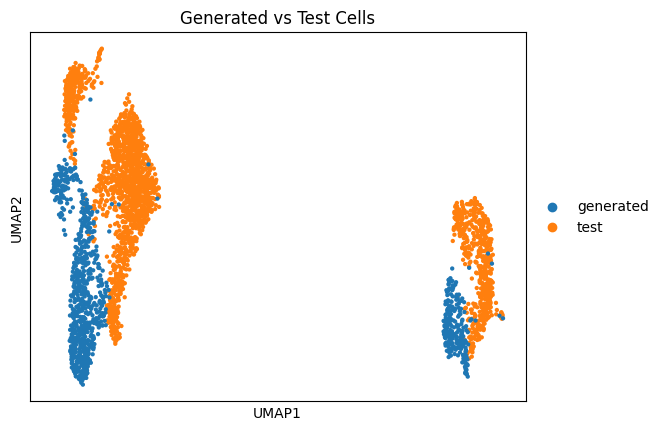

In [9]:
merged_adata = adata_test.concatenate(adata_gen, batch_key="batch", batch_categories=["test", "generated"])
# Preprocess
#sc.pp.normalize_total(merged_adata, target_sum=1e4)
#sc.pp.log1p(merged_adata)
#sc.pp.highly_variable_genes(merged_adata, flavor="seurat", n_top_genes=2000)
#merged_adata = merged_adata[:, merged_adata.var.highly_variable]
sc.pp.scale(merged_adata)

# PCA and neighbors
sc.tl.pca(merged_adata, svd_solver='arpack')
sc.pp.neighbors(merged_adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(merged_adata)

# Plot
sc.pl.umap(merged_adata, color="dataset", title="Generated vs Test Cells")


UMAP shows very similar clustering between generated data and test data (flow was not trained with it). This shows our model not only replicates the training data with high fidelity, but it also generates data that is realistic and behaves in a similar way to test data.

### Qualitative plots

In [10]:
import utils.qual_eval_plots as qual_eval_plots

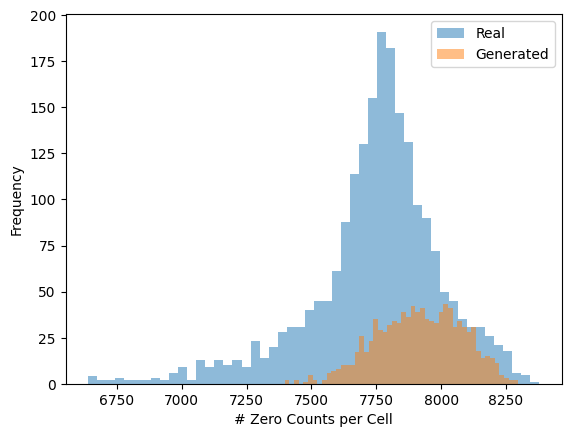

In [12]:
qual_eval_plots.sparsity_plot(test_path, gen_adata_path)

Generated data conserves sparsity, which is characteristic of RNAseq data.

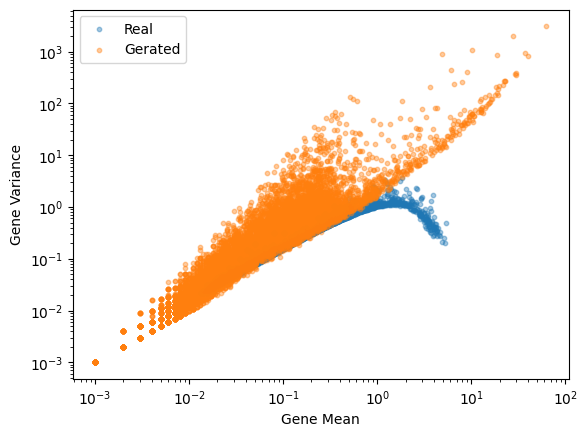

In [13]:
qual_eval_plots.overdispersion_plot(test_path, gen_adata_path)

Generated data shows similar trend regarding its overdispersion, which is characteristic of RNAseq data.

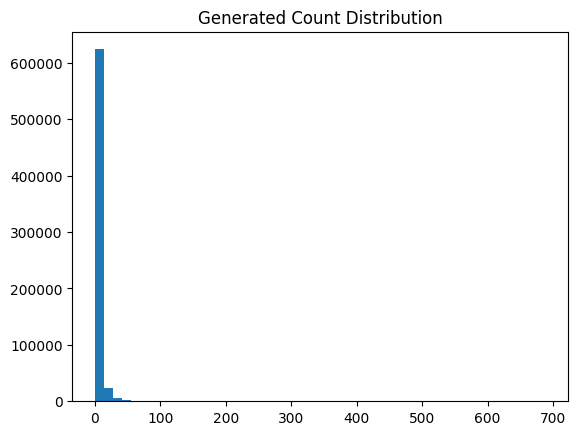

In [14]:
qual_eval_plots.discreteness_plot(test_path, gen_adata_path)

Once again, we can see that our generated data is sparse, as most genes are not expressed at a time.

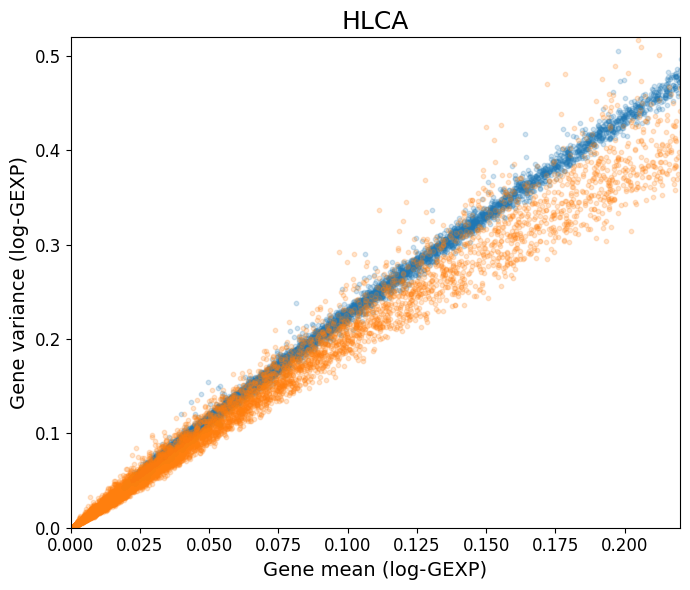

In [15]:
qual_eval_plots.hlca_plot(test_path, gen_adata_path)

This other representation of the overdispersion highlights the success of the model at capturing this feature of RNAseq data.

Real shape: (2110, 8573)
Generated shape: (1000, 8573)


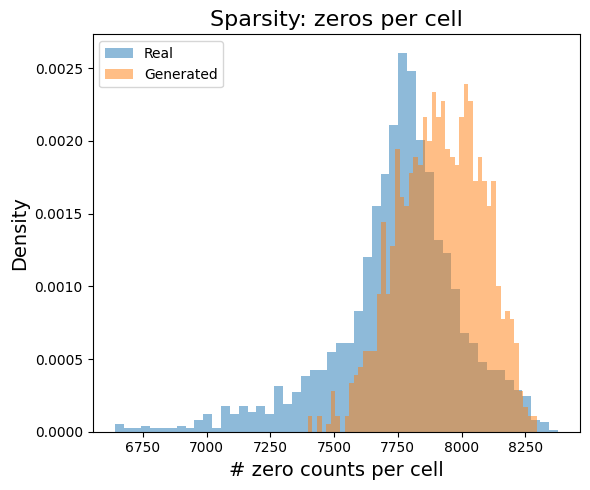

In [16]:
qual_eval_plots.sparsity_density_plot(test_path, gen_adata_path)

After scaling the data, we can see that sparsity is modelled quite accurately, with a great overalp betweeen test and generated distribution. However, the shapes of the distributions are not the same, which may be due to the way the library size was simulated in our model. We chose a beta distribution which had much less spikes than the real library size distribution, but had it's same range and mean. As a result, we obtained a biased model with not as much variance as in real data. 

## CFG generated data
Comparison ofCFG generated data with the real data

Running PCA and UMAP on merged dataset...

--- Starting Visualization Generation ---


/work3/s243171/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/work3/s243171/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


NameError: name 'flow_model_save_path' is not defined

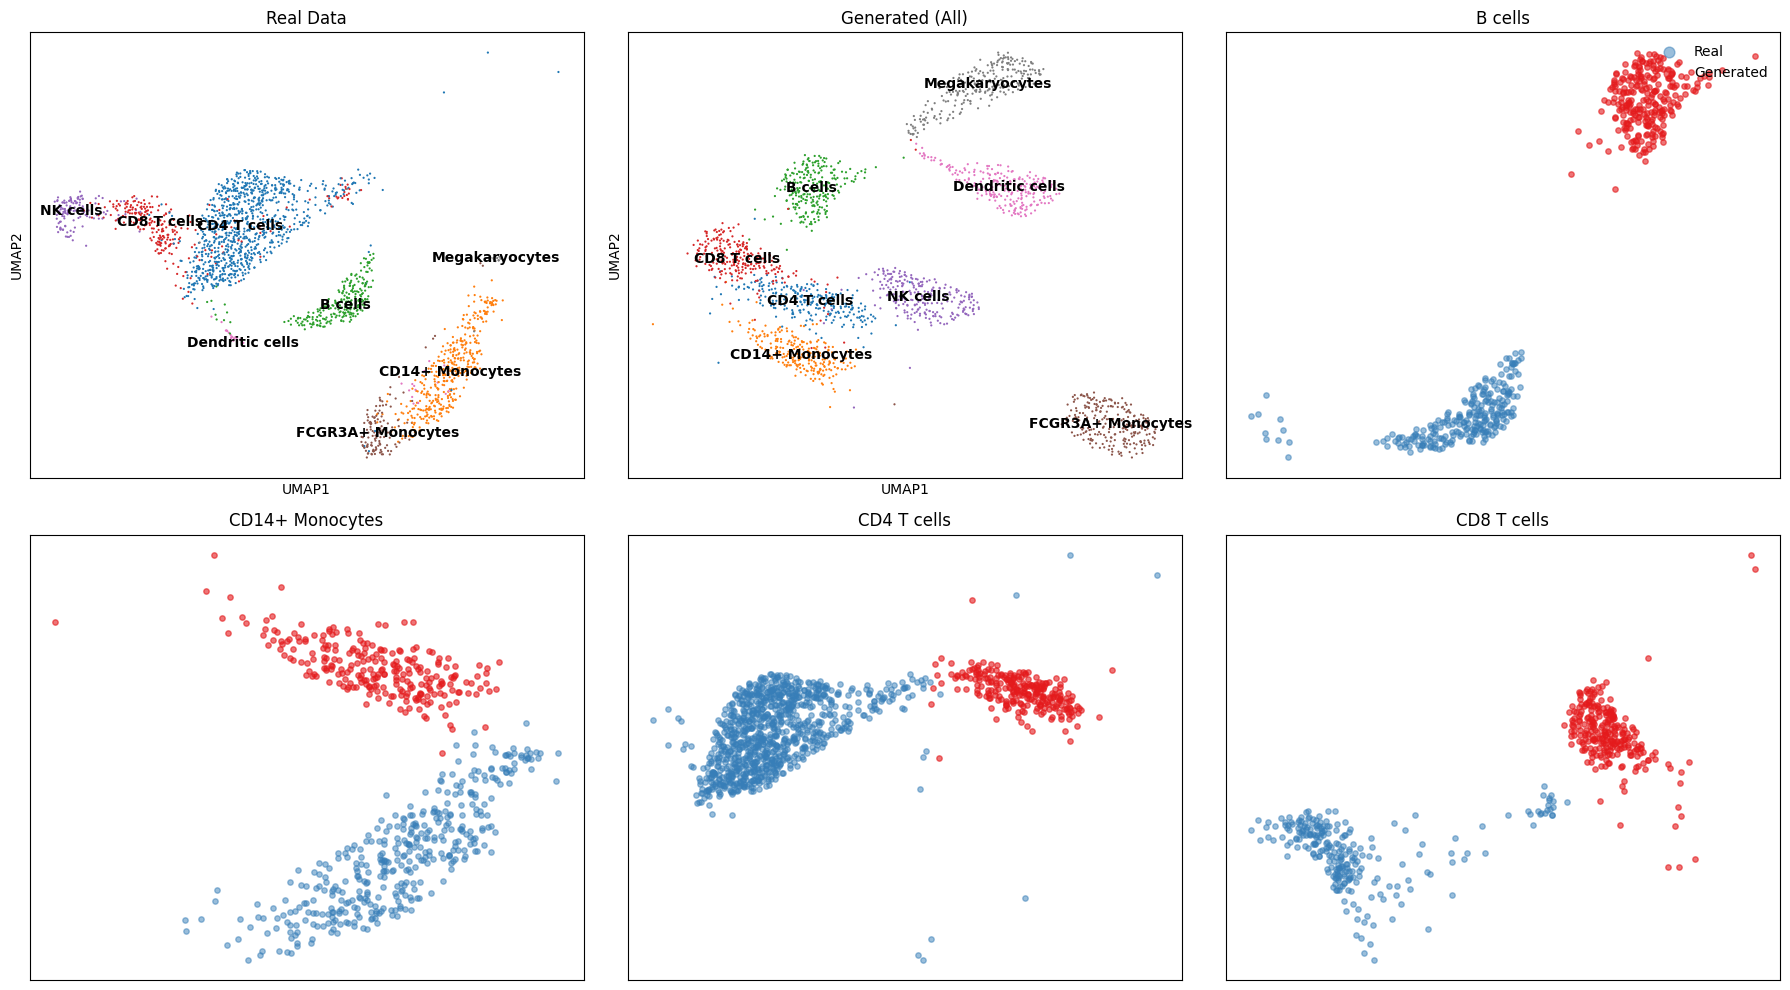

In [ ]:
import sys
sys.path.append("../../")
from utils.classifier_free_guidance import *

test_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_with_latent.h5ad" #same as above
cfg_data_path = "/dtu/blackhole/06/213542/paperdata/generated_cells.h5ad" # generated data 
adata = ad.read_h5ad(test_path)
save_path = "/dtu/blackhole/06/213542/paperdata/"
try:
    adata_gen = ad.read_h5ad(cfg_data_path)
except Exception:
    print(f"Generated data file not found at {cfg_data_path}. Please generate the data using cfg_sample_and_plot.py first.")

# Prepare Merged Dataset
adata_real = adata.copy()
adata_real.obs['dataset'] = 'Real'
if hasattr(adata_real.X, "toarray"):
    adata_real.X = adata_real.X.toarray()

adata_merged = ad.concat([adata_real, adata_gen], join='outer', label='batch', keys=['Real', 'Generated'])
adata_merged.obs['cell_type'] = adata_merged.obs['cell_type'].astype('category')

# Preprocessing & Embedding
print("Running PCA and UMAP on merged dataset...")
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)
sc.pp.pca(adata_merged, n_comps=30)
sc.pp.neighbors(adata_merged, n_neighbors=15)
sc.tl.umap(adata_merged)

# Visualization
print("\n--- Starting Visualization Generation ---")
highlight_types = ['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells']

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, figure=fig)

# Panel 1: Real Data
ax1 = fig.add_subplot(gs[0, 0])
plot_umap_scatter(ax1, adata_merged[adata_merged.obs['dataset']=='Real'], 
                  'cell_type', 'Real Data')

# Panel 2: Generated Data
ax2 = fig.add_subplot(gs[0, 1])
plot_umap_scatter(ax2, adata_merged[adata_merged.obs['dataset']=='Generated'], 
                  'cell_type', 'Generated (All)')

# Overlap Panels
locs = [(0, 2), (1, 0), (1, 1), (1, 2)]
for i, c_type in enumerate(highlight_types):
    if i >= len(locs): break
    ax = fig.add_subplot(gs[locs[i]])
    plot_overlap(ax, c_type, adata_merged)
    if i == 0:
        ax.legend(frameon=False, loc='upper right', markerscale=2)

plt.tight_layout()
save_plot_path = os.path.join(os.path.dirname(save_path), "cfgen_results_figure_a2.png")
plt.savefig(save_plot_path, dpi=300)
print(f"Figure saved to {save_plot_path}")
plt.show()